# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
# System libraries
import copy
import random
import json
import numpy as np
from collections import namedtuple, deque

# Visualization
import matplotlib.pyplot as plt

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000178813934
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 4.1. Utils Functions

In [7]:
def seeding(seed=10):
    """Set Seeds."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def hidden_init(layer):
    """Set Hidden initialization arguments"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

### 4.2. Actor Critic Models

In [8]:

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=10, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.

        :param: state_size: Dimension of each state
        :param: action_size: Dimension of each action
        :param: seed: Random seed
        :param fc1_units: Number of nodes in first hidden layer
        :param fc2_units: Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))
    

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=10, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        :param: state_size: Dimension of each state
        :param: action_size: Dimension of each action
        :param: seed: Random seed
        :param: fcs1_units: Number of nodes in the first hidden layer
        :param: fc2_units: Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)


### 4.3. Multi-Agent DDPG

#### 4.3.1. Base DDPG Algorithm

In [9]:
class DDPG(object):
    """Interacts with and learns from the environment.
    
    There are two agents and the observations of each agent has 24 dimensions. 
    
    Each agent's action has 2 dimensions.
    
    
    We will use two separate actor networks (one for each agent using each agent's observations only and output that agent's action).
    The critic for each agents gets to see the actions and observations of all agents. 
    """
    
    def __init__(self, state_size, action_size, num_agents):
        """Initialize an Agent object.
        :param: state_size (int): dimension of each state for each agent
        :param: action_size (int): dimension of each action for each agent
        """
        self.state_size = state_size
        self.action_size = action_size        

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(DEVICE)
        self.actor_target = Actor(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), 
                                          lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), 
                                           lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        self.noise = OUNoise(action_size) 
        self.noise_scale = NOISE_START
    
        # Make sure target is initialized with the same weight as the source (makes a big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def act(self, states, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        if i_episode > EPISODES_BEFORE_TRAINING and self.noise_scale > NOISE_END:
            self.noise_scale = NOISE_REDUCTION**(i_episode-EPISODES_BEFORE_TRAINING)

            if not add_noise:
                self.noise_scale = 0.0
                                    
        states = torch.from_numpy(states).float().to(DEVICE)
        self.actor_local.eval()
        
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        
        self.actor_local.train()
        actions += self.noise_scale*self.add_noise2() #works much better than OU Noise process
        
        return np.clip(actions, -1, 1)

    def add_noise2(self):
        noise = 0.5 * np.random.randn(1, self.action_size)
        return noise
        
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        :param: experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        :param: gamma (float): discount factor
        """
        full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, full_next_states, critic_full_next_actions = experiences
        
        # Get Q values from target models
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)
        
        # Compute Q targets for current states (y_i)
        Q_target = agent_rewards + gamma * Q_target_next * (1 - agent_dones)
        
        # Compute critic loss
        Q_expected = self.critic_local(full_states, full_actions)
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target) #target=Q_targets.detach() #not necessary to detach
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()
        
        # Compute actor loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean() #-ve b'cse we want to do gradient ascent
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                  

        
    def soft_update_all(self):
        """Update Target Network parameters."""
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)


   
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target


        :param: local_model: PyTorch model (weights will be copied from)
        :param: target_model: PyTorch model (weights will be copied to)
        :param: tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise(object):
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["full_state", "state", "action", "reward", \
                                                                "full_next_state", "next_state", "done"])

    def add(self, full_state, state, action, reward, full_next_state, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(full_state, state, action, reward, full_next_state, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(DEVICE)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        full_next_states = torch.from_numpy(np.array([e.full_next_state for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)

        return (full_states, states, actions, rewards, full_next_states, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
class MADDPG(object):
    """The main class that defines and trains all the agents."""
    
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.whole_action_dim = self.action_size*self.num_agents
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.maddpg_agents = [DDPG(state_size, action_size, num_agents), DDPG(state_size, action_size, num_agents)] #create agents
        self.episodes_before_training = EPISODES_BEFORE_TRAINING
        
    def reset(self):
        for agent in self.maddpg_agents:
            agent.reset()

    def step(self, i_episode, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        # index 0 is for agent 0 and index 1 is for agent 1
        full_states = np.reshape(states, newshape=(-1))
        full_next_states = np.reshape(next_states, newshape=(-1))
        
        # Save experience / reward
        self.memory.add(full_states, states, actions, rewards, full_next_states, next_states, dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and i_episode > self.episodes_before_training:
            for _ in range(NUM_LEARN_STEPS_PER_ENV_STEP): #learn multiple times at every step
                for agent_no in range(self.num_agents):
                    samples = self.memory.sample()
                    self.learn(samples, agent_no, GAMMA)
                self.soft_update_all()

    def soft_update_all(self):
        """Soft update all the agents."""            
        for agent in self.maddpg_agents:
            agent.soft_update_all()
    
    def learn(self, samples, agent_no, gamma):
        #for learning MADDPG
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        critic_full_next_actions = torch.zeros(states.shape[:2] + (self.action_size,), dtype=torch.float, device=DEVICE)
        for agent_id, agent in enumerate(self.maddpg_agents):
            agent_next_state = next_states[:,agent_id,:]
            critic_full_next_actions[:,agent_id,:] = agent.actor_target.forward(agent_next_state)
        critic_full_next_actions = critic_full_next_actions.view(-1, self.whole_action_dim)
        
        agent = self.maddpg_agents[agent_no]
        agent_state = states[:,agent_no,:]
        actor_full_actions = actions.clone() #create a deep copy
        actor_full_actions[:,agent_no,:] = agent.actor_local.forward(agent_state)
        actor_full_actions = actor_full_actions.view(-1, self.whole_action_dim)
                
        full_actions = actions.view(-1,self.whole_action_dim)
        
        agent_rewards = rewards[:,agent_no].view(-1,1) #gives wrong result without doing this
        agent_dones = dones[:,agent_no].view(-1,1) #gives wrong result without doing this
        experiences = (full_states, actor_full_actions, full_actions, agent_rewards, \
                       agent_dones, full_next_states, critic_full_next_actions)
        agent.learn(experiences, gamma)

    def learn_double_ddpg(self, samples, agent_no, gamma):
        #for learning double ddpg (for debug only, do not use this)
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        temp_agent_no = np.random.randint(0,2) #to decide which agent's experience to use
        strt = temp_agent_no * self.state_size
        stp = strt + self.state_size
        full_states = full_states[:, strt:stp]
        states = states[:,temp_agent_no]
        actions = actions[:,temp_agent_no]
        rewards = rewards[:,temp_agent_no]
        full_next_states = full_next_states[:,strt:stp]
        next_states = next_states[:,temp_agent_no]
        dones = dones[:,temp_agent_no]
        
        
        agent = self.maddpg_agents[agent_no]
        critic_full_next_actions = agent.actor_target.forward(next_states)
        actor_full_actions = agent.actor_local.forward(states)
        full_actions = actions
        
        experiences = (full_states, actor_full_actions, full_actions, rewards, \
                        dones, full_next_states, critic_full_next_actions)
        
        agent.learn(experiences, gamma)

            
    def act(self, full_states, i_episode, add_noise=True):
        """All actions between -1 and 1."""
        actions = []
        for agent_id, agent in enumerate(self.maddpg_agents):
            action = agent.act(np.reshape(full_states[agent_id,:], newshape=(1,-1)), i_episode, add_noise)
            action = np.reshape(action, newshape=(1,-1))            
            actions.append(action)
        actions = np.concatenate(actions, axis=0)
        return actions

    def save_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local_' + str(agent_id) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local_' + str(agent_id) + '.pth')

    def load_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            #Since the model is trained on gpu, need to load all gpu tensors to cpu:
            agent.actor_local.load_state_dict(torch.load('checkpoint_actor_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.critic_local.load_state_dict(torch.load('checkpoint_critic_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))

            agent.noise_scale = NOISE_END #initialize to the final epsilon value upon training


#### 4.4. Set Training Constants

In [11]:
#Constants
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 256        
GAMMA = 0.99            
TAU = 1e-3              
LR_ACTOR = 1e-4 
LR_CRITIC = 3e-4 
WEIGHT_DECAY_actor = 0.0 
WEIGHT_DECAY_critic = 0.0 
NOISE_START=1.0
NOISE_END=0.1
NOISE_REDUCTION=0.999
EPISODES_BEFORE_TRAINING = 300
NUM_LEARN_STEPS_PER_ENV_STEP = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seeding(seed=2)
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPG_obj = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)

In [12]:
def run_training(n_episodes=2500, t_max=1000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    scores_list_100_avg = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        MADDPG_obj.reset() #reset the MADDPG_obj OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent in MADDPG)
        num_steps = 0
        for _ in range(t_max):
            actions = MADDPG_obj.act(states, i_episode)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent in MADDPG)
            rewards = env_info.rewards                         # get rewards (for each agent in MADDPG)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent in MADDPG)
            MADDPG_obj.step(i_episode, states, actions, rewards, next_states, dones) #train the MADDPG_obj           
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
            #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_list_100_avg.append(np.mean(scores_deque))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        #print('Episode {}\tAverage Score: {:.2f}\tCurrent Score: {}'.format(i_episode, np.mean(scores_deque), np.max(scores)))
        #print('Noise Scaling: {}, Memory size: {} and Num Steps: {}'.format(MADDPG_obj.maddpg_agents[0].noise_scale, len(MADDPG_obj.memory), num_steps))
        
        if i_episode % 50 == 0:
            MADDPG_obj.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 1.0 and len(scores_deque) >= 100:
            MADDPG_obj.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list, scores_list_100_avg

In [13]:
from session import active_session

with active_session():
    scores, scores_avg = run_training()

Saved Model: Episode 50	Average Score: 0.01
Saved Model: Episode 100	Average Score: 0.01
Saved Model: Episode 150	Average Score: 0.02
Saved Model: Episode 200	Average Score: 0.02
Saved Model: Episode 250	Average Score: 0.02
Saved Model: Episode 300	Average Score: 0.02
Saved Model: Episode 350	Average Score: 0.01
Saved Model: Episode 400	Average Score: 0.00
Saved Model: Episode 450	Average Score: 0.01
Saved Model: Episode 500	Average Score: 0.03
Saved Model: Episode 550	Average Score: 0.01
Saved Model: Episode 600	Average Score: 0.01
Saved Model: Episode 650	Average Score: 0.02
Saved Model: Episode 700	Average Score: 0.05
Saved Model: Episode 750	Average Score: 0.07
Saved Model: Episode 800	Average Score: 0.08
Saved Model: Episode 850	Average Score: 0.07
Saved Model: Episode 900	Average Score: 0.07
Saved Model: Episode 950	Average Score: 0.09
Saved Model: Episode 1000	Average Score: 0.11
Saved Model: Episode 1050	Average Score: 0.12
Saved Model: Episode 1100	Average Score: 0.13
Saved Mo

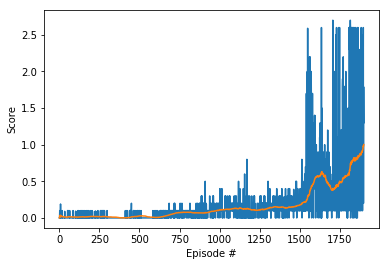

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()